# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).



In [6]:
con = sqlite3.connect('data.sqlite') 
df = pd.read_sql_query(""" SELECT * FROM Reviews""", con) 
text=df['CleanedText']
label=df['Score']
x,x_test,y,y_test=train_test_split(text,label,test_size=0.2,random_state=0, stratify=label)
x_train,x_cv,y_train,y_cv=train_test_split(x,y,test_size=0.25, random_state=0, stratify=y)
x_train.shape


(61824,)

In [38]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
#import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from mpl_toolkits import mplot3d
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report, confusion_matrix 
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
#import xgboost as xgb
#from xgboost import XGBClassifier
#from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from wordcloud import WordCloud

# [4] Featurization

## [4.1] BAG OF WORDS

In [8]:
vect=CountVectorizer().fit(x_train)
train_cnt=vect.transform(x_train)
cv_cnt=vect.transform(x_cv)
test_cnt=vect.transform(x_test)
cv_cnt.shape

(20608, 47108)

## [4.3] TF-IDF

In [9]:
idf=TfidfVectorizer().fit(x_train)
train_tf=idf.transform(x_train)
test_tf=idf.transform(x_test)
cv_tf=idf.transform(x_cv)

## [4.4] Word2Vec

In [10]:
list_of_words=[]
for x in x_train.values:
    list_of_words.append(x.split())
    
w2v_model=Word2Vec(list_of_words, min_count=5, size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
                 


w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [11]:
test_word_list=[]
for x in x_test.values:
    test_word_list.append(x.split())
    
cv_word_list=[]
for x in x_cv.values:
    cv_word_list.append(x.split())
    
train_w2v=[];
for x in (list_of_words):
    sent_vec=np.zeros(50)
    cnt_words=0
    for y in x:
        if y in w2v_words:
            vec=w2v_model.wv[y]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_w2v.append(sent_vec)
    
    
cv_w2v=[];
for x in (cv_word_list):
    sent_vec=np.zeros(50)
    cnt_words=0
    for y in x:
        if y in w2v_words:
            vec=w2v_model.wv[y]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_w2v.append(sent_vec)

test_w2v=[]
for x in (test_word_list):
    sent_vec=np.zeros(50)
    cnt_words=0
    for y in x:
        if y in w2v_words:
            vec=w2v_model.wv[y]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_w2v.append(sent_vec)

#### [4.4.1.2] TFIDF weighted W2v

In [12]:
model = TfidfVectorizer()
model.fit_transform(x_train.values)

dicti= dict(zip(model.get_feature_names(), list(model.idf_)))

tfidf_feat = model.get_feature_names() 

In [13]:
train_df= [];
row=0;
for sent in (list_of_words): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            
    
            tf_idf = dicti[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_df.append(sent_vec)
    row += 1
    
tfidf_feat = model.get_feature_names() 

test_df= []; 
row=0;
for sent in (test_word_list):
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]

            tf_idf = dicti[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_df.append(sent_vec)
    row += 1
    
    
cv_df= []; 
row=0;
for sent in (cv_word_list):
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]

            tf_idf = dicti[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_df.append(sent_vec)
    row += 1

### Function to tune hyperparameters

In [26]:
def tuning(train, cv, y_train, y_cv):
    roc_scores_cv=[]
    roc_scores_train=[]
    final_train=[]
    final_cv=[]
    depth_list=[2,3,4,5,6,7,8,9,10]
    estimators_list=[5,10,50,100,200,500,1000]
    for i in estimators_list:
        for x in depth_list:
            clf=RandomForestClassifier(max_depth=x, n_estimators=i,class_weight='balanced',n_jobs=-1)
            clf.fit(train,y_train)
            prob_cv=clf.predict_proba(cv)[:,1]
            prob_train=clf.predict_proba(train)[:,1]
            roc_cv=roc_auc_score(y_cv,prob_cv)
            roc_train=roc_auc_score(y_train,prob_train)
            roc_scores_cv.append(roc_cv)
            roc_scores_train.append(roc_train)
        final_train.append(roc_scores_train)
        roc_scores_train=[]
        final_cv.append(roc_scores_cv)
        roc_scores_cv =[]
    plt.figure(figsize=(10,10))
    ax1=plt.subplot(2,1,1)
    sns.heatmap(final_cv,annot=True ,fmt=".2f",ax=ax1,linewidth=0.3)   
    plt.xticks(np.arange(len(depth_list)), depth_list)
    plt.xlabel("Depth")
    plt.ylabel('Number of estimators')
    plt.yticks(np.arange(len(estimators_list)),estimators_list)
    ax1.set_title('CV Dataset')
    ax2=plt.subplot(2,1,2)
    sns.heatmap(final_train,annot=True ,fmt=".2f",ax=ax2)   
    plt.xticks(np.arange(len(depth_list)), depth_list)
    plt.yticks(np.arange(len(estimators_list)),estimators_list)
    plt.xlabel("Depth")
    plt.ylabel('Number of estimators')
    ax2.set_title('Training Dataset')
    plt.show()
    

### Function to plot ROC curves.

In [30]:
def rocPlot(train_data, test_data, y_train, y_test):
    pred_proba = clf.predict_proba(test_data)[:,1]
    fpr,tpr, thresholds=roc_curve(y_test, pred_proba)
    roc_auc=roc_auc_score(y_test, pred_proba)
    plt.plot(fpr, tpr, label='AUC= %0.3f for test set' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    pred_probat = clf.predict_proba(train_data)[:,1]
    fpr,tpr, thresholds=roc_curve(y_train, pred_probat)
    roc_auc=roc_auc_score(y_train, pred_probat)
    plt.plot(fpr, tpr, label='AUC= %0.3f for training set' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curves of train and test data')
    plt.legend(loc="lower right")
    plt.show()

### Function to plot Confusion matrix

In [31]:
def con_mx(target1, predict1, target2, predict2):
    cm = confusion_matrix(target1, predict1)
    cm2=confusion_matrix(target2, predict2)
    cm = pd.DataFrame(cm)
    cm2 = pd.DataFrame(cm2)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    cm2.index.name = 'Actual'
    cm2.columns.name = 'Predicted'
    fig, (ax1,ax2)= plt.subplots(1,2)
    ax1.set_title('Training Dataset')
    ax2.set_title('Test Dataset')
    sns.heatmap(cm, annot=True, fmt='d', ax=ax1)
    sns.heatmap(cm2, annot=True, fmt='d', ax=ax2)


## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

### Hyperparameter tuning to find optimal depth and number of estimators

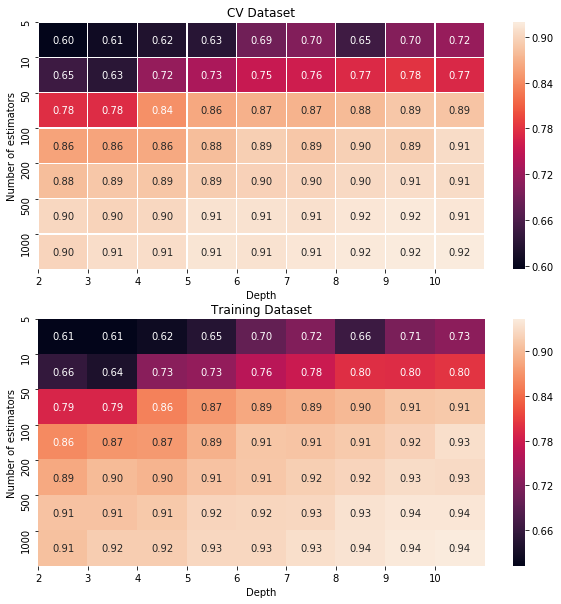

In [27]:
tuning(train_cnt,cv_cnt,y_train,y_cv)

Tuning the parameters max depth and no of estimators to find optimal value which gives highest AUC score. Since, RF models are high variance and low bias, i.e., they while training each models will be overfitted(high varaiance), which as a result will lead to low variance, low bias model as final model. 

In [33]:
# Please write all the code with proper documentation
clf=RandomForestClassifier(max_depth=9, n_estimators=1000,class_weight='balanced')
clf.fit(train_cnt,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

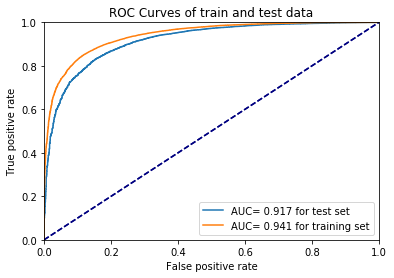

In [34]:
rocPlot(train_cnt, test_cnt, y_train, y_test)

We can see that difference b/w train and test auc is not large. So, the final model is not overfitting.

### Confusion matrix plot training and test dataset

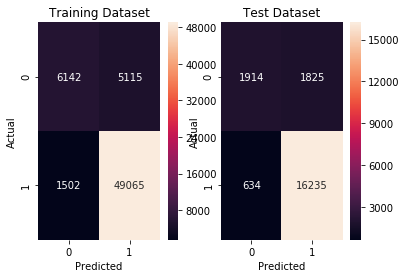

In [35]:
pred_train=clf.predict(train_cnt)
pred_test=clf.predict(test_cnt)
con_mx(pred_train, y_train, pred_test, y_test)

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

(-0.5, 399.5, 199.5, -0.5)

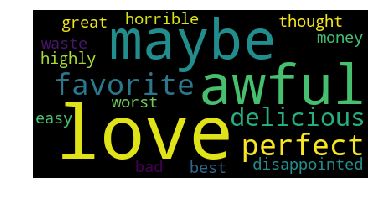

In [39]:
lst=[]
coef=clf.feature_importances_
top_20=np.argpartition(coef,-20)[-20:]
for i in top_20:
    lst.append(vect.get_feature_names()[i])
str=(" ").join(lst)
wordcloud=WordCloud().generate(str)
plt.imshow(wordcloud)
plt.axis("off")

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

### Hyperparameter tuning to find optimal depth and number of estimators

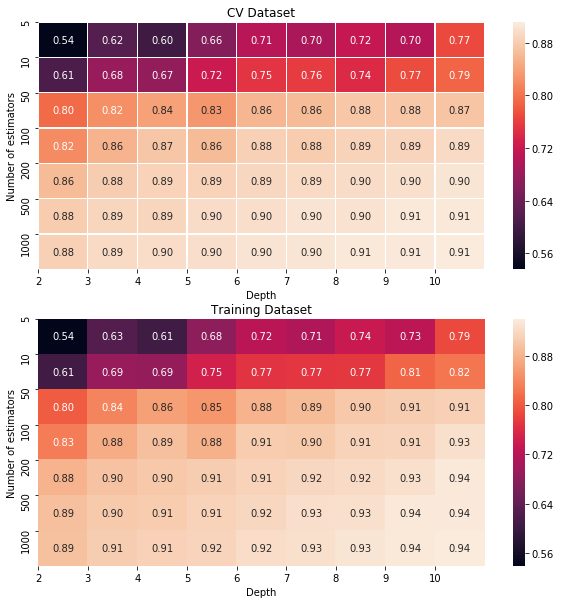

In [40]:
tuning(train_tf,cv_tf,y_train,y_cv)

In [41]:
# Please write all the code with proper documentation
clf=RandomForestClassifier(max_depth=10, n_estimators=1000,class_weight='balanced')
clf.fit(train_tf,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

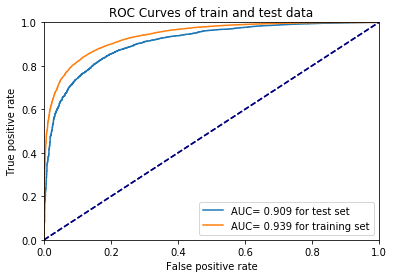

In [42]:
rocPlot(train_tf,test_tf, y_train, y_test)

### Confusion matrix plot training and test dataset

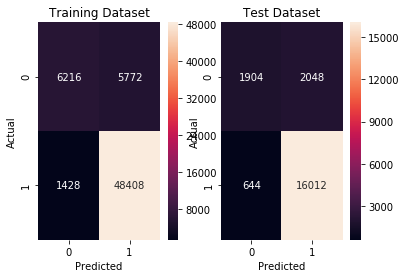

In [43]:
pred_train=clf.predict(train_tf)
pred_test=clf.predict(test_tf)
con_mx(pred_train, y_train, pred_test, y_test)

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

(-0.5, 399.5, 199.5, -0.5)

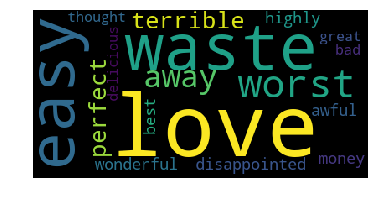

In [44]:
lst=[]
coef=clf.feature_importances_
top_20=np.argpartition(coef,-20)[-20:]
for i in top_20:
    lst.append(idf.get_feature_names()[i])
str=(" ").join(lst)
wordcloud=WordCloud().generate(str)
plt.imshow(wordcloud)
plt.axis("off")

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

### Hyperparameter tuning to find optimal depth and number of estimators

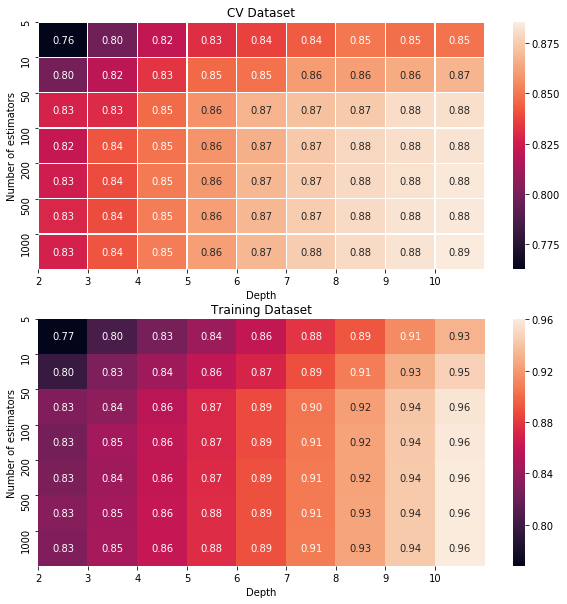

In [45]:
tuning(train_w2v,cv_w2v,y_train,y_cv)

In [50]:
# Please write all the code with proper documentation
clf=RandomForestClassifier(max_depth=10, n_estimators=500,class_weight='balanced',n_jobs=-1)
clf.fit(train_w2v,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

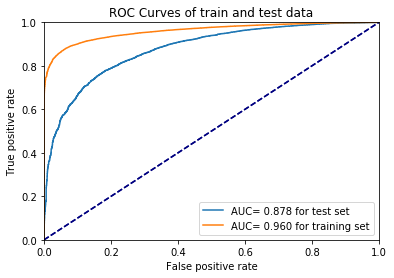

In [51]:
rocPlot(train_w2v,test_w2v, y_train, y_test)

### Confusion matrix plot training and test dataset

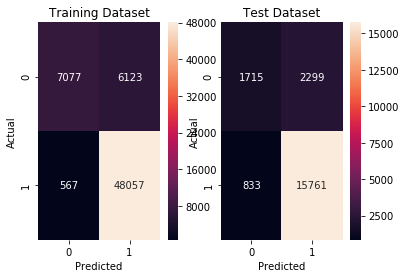

In [52]:
pred_train=clf.predict(train_w2v)
pred_test=clf.predict(test_w2v)
con_mx(pred_train, y_train, pred_test, y_test)

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

### Hyperparameter tuning to find optimal depth and number of estimators

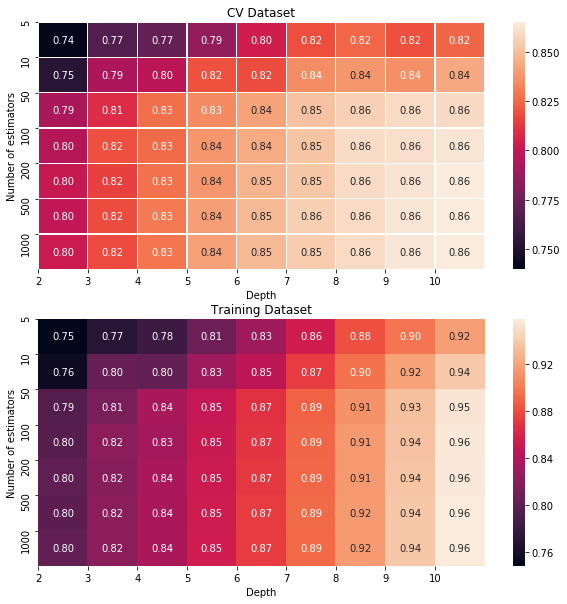

In [46]:
tuning(train_df,cv_df,y_train,y_cv)

In [53]:
# Please write all the code with proper documentation
clf=RandomForestClassifier(max_depth=9, n_estimators=500,class_weight='balanced',n_jobs=-1)
clf.fit(train_df,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

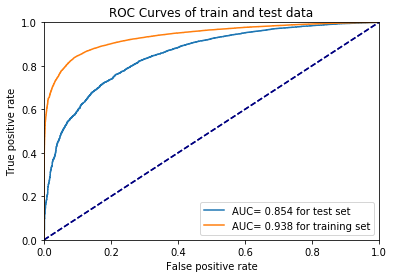

In [54]:
rocPlot(train_df,test_df, y_train, y_test)

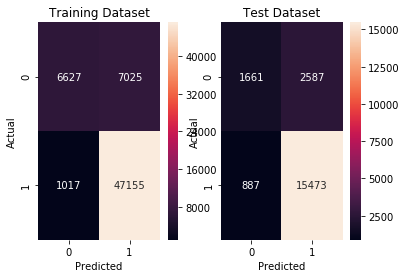

In [55]:
pred_train=clf.predict(train_df)
pred_test=clf.predict(test_df)
con_mx(pred_train, y_train, pred_test, y_test)

## [5.2] Applying GBDT using LightGBM

Using Framework LightGBM instead of xgboost since xgboost was taking long time to train. On the contrary, LGBM provides a bit better or almost same accuracy but with much faster training rate. I'm taking 50k data points as LGBM is not suitable for large dataset as it become more prone to overfitting.

In [40]:
data=df['CleanedText'].head(50000)
target=df['Score'].head(50000)
x_50,x_test_50,y_50,y_test_50=train_test_split(data,target,test_size=0.2,random_state=0, stratify=target)
x_train_50,x_cv_50,y_train_50,y_cv_50=train_test_split(x_50,y_50,test_size=0.25, random_state=0, stratify=y_50)
x_train_50.shape

(30000,)

BOW, TFIDF, AVG W2V & TFIDF AVG W2V Vectorizers with 50k data points

In [41]:
#BOW
vect=CountVectorizer(dtype=np.float64).fit(x_train_50)
train_bow=vect.transform(x_train_50)
cv_bow=vect.transform(x_cv_50)
test_bow=vect.transform(x_test_50)
cv_bow.shape
#TFIDF
tf=TfidfVectorizer(dtype=np.float64).fit(x_train_50)
tf_train=tf.transform(x_train_50)
tf_cv=tf.transform(x_cv_50)
tf_test=tf.transform(x_test_50)

In [59]:
list_of_words=[]
for x in x_train_50.values:
    list_of_words.append(x.split())
    
w2v_model=Word2Vec(list_of_words, min_count=5, size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)


#AVG W2V
test_word_list=[]
for x in x_test_50.values:
    test_word_list.append(x.split())
    
cv_word_list=[]
for x in x_cv_50.values:
    cv_word_list.append(x.split())
    
train_w2v_50=[];
for x in tqdm(list_of_words):
    sent_vec=np.zeros(50)
    cnt_words=0
    for y in x:
        if y in w2v_words:
            vec=w2v_model.wv[y]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_w2v_50.append(sent_vec)
    
    
cv_w2v_50=[];
for x in tqdm(cv_word_list):
    sent_vec=np.zeros(50)
    cnt_words=0
    for y in x:
        if y in w2v_words:
            vec=w2v_model.wv[y]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_w2v_50.append(sent_vec)

test_w2v_50=[]
for x in tqdm(test_word_list):
    sent_vec=np.zeros(50)
    cnt_words=0
    for y in x:
        if y in w2v_words:
            vec=w2v_model.wv[y]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_w2v_50.append(sent_vec)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.83it/s]


In [ ]:
#TFIDF AVG W2V
model = TfidfVectorizer()
model.fit_transform(x_train_50.values)

dicti= dict(zip(model.get_feature_names(), list(model.idf_)))

tfidf_feat = model.get_feature_names() 



train_df_50= [];
row=0;
for sent in tqdm(list_of_words): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            
    
            tf_idf = dicti[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_df_50.append(sent_vec)
    row += 1
    
tfidf_feat = model.get_feature_names() 

test_df_50= []; 
row=0;
for sent in tqdm(test_word_list):
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]

            tf_idf = dicti[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_df_50.append(sent_vec)
    row += 1
    
    
cv_df_50= []; 
row=0;
for sent in tqdm(cv_word_list):
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]

            tf_idf = dicti[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_df_50.append(sent_vec)
    row += 1

In [42]:
def tune(train,cv,y_train,y_cv):
    roc_scores_cv=[]
    roc_scores_train=[]
    final_train=[]
    final_cv=[]
    depth_list=[2,3,4,5,6,7,8,9,10]
    estimators_list=[5,10,50,100,200,500,1000]
    for i in estimators_list:
        for x in depth_list:
            clf=LGBMClassifier(max_depth=x, n_estimators=i,objective='binary',class_weight='balanced')
            clf.fit(train,y_train)
            prob_cv=clf.predict_proba(cv)[:,1]
            prob_train=clf.predict_proba(train)[:,1]
            roc_cv=roc_auc_score(y_cv,prob_cv)
            roc_train=roc_auc_score(y_train,prob_train)
            roc_scores_cv.append(roc_cv)
            roc_scores_train.append(roc_train)
        final_train.append(roc_scores_train)
        roc_scores_train=[]
        final_cv.append(roc_scores_cv)
        roc_scores_cv=[]
    z_train=np.array(final_train)
    z_cv=np.array(final_cv)
    A,B=np.meshgrid(depth_list,estimators_list)
    fig=plt.figure()
    ax1=fig.add_subplot(121,projection='3d')
    ax2=fig.add_subplot(122,projection='3d')
    #ax1.set_title('Training Dataset')
    ax1.plot_surface(A, B, z_train,label='training')
    ax1.set_xlabel("depth")
    ax1.set_ylabel("Number of estimators")
    ax1.set_zlabel('AUC Score')
    ax1.set_title('Training Dataset')
    ax2.plot_surface(A, B, z_cv,label='cv')
    ax2.set_title('CV Dataset')
    ax2.set_xlabel("depth")
    ax2.set_ylabel("Number of estimators")
    ax2.set_zlabel('AUC Score')
    plt.show()

### [5.2.1] Applying GBDT on BOW,<font color='red'> SET 1</font>

### Hyperparameter tuning to find optimal depth and number of estimators

<IPython.core.display.Javascript object>


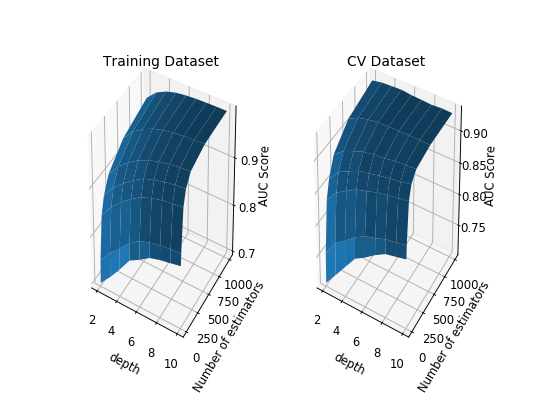

In [86]:
tune(train_bow,cv_bow,y_train_50,y_cv_50)

In [99]:
clf=LGBMClassifier(max_depth=6, n_estimators=700, class_weight='balanced')
clf.fit(train_bow,y_train_50)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
        max_depth=6, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=700, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

<IPython.core.display.Javascript object>


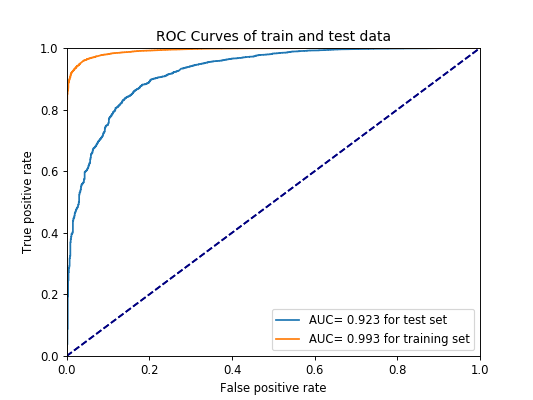

In [100]:
rocPlot(train_bow, test_bow, y_train_50, y_test_50)

### Confusion matrix plot training and test dataset

<IPython.core.display.Javascript object>


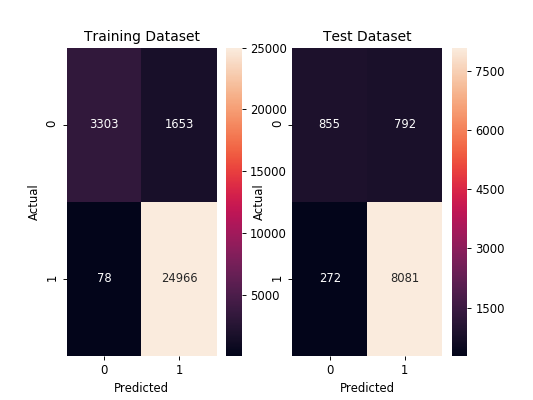

In [101]:
pred_train=clf.predict(train_bow)
pred_test=clf.predict(test_bow)
con_mx(pred_train, y_train_50, pred_test, y_test_50)

## ### [5.2.2] Applying GBDT on TFIDF,<font color='red'> SET 2</font>

### Hyperparameter tuning to find optimal depth and number of estimators

<IPython.core.display.Javascript object>


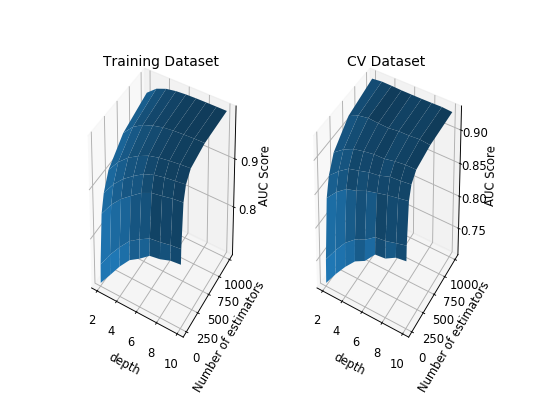

In [49]:
tune(tf_train,tf_cv,y_train_50,y_cv_50)

In [55]:
clf=LGBMClassifier(max_depth=8, n_estimators=450, class_weight='balanced')
clf.fit(tf_train,y_train_50)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
        max_depth=8, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=450, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

<IPython.core.display.Javascript object>


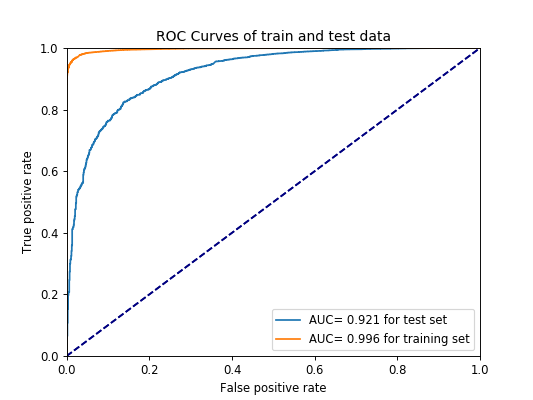

In [56]:
rocPlot(tf_train, tf_test, y_train_50, y_test_50)

### Confusion matrix plot training and test dataset

<IPython.core.display.Javascript object>


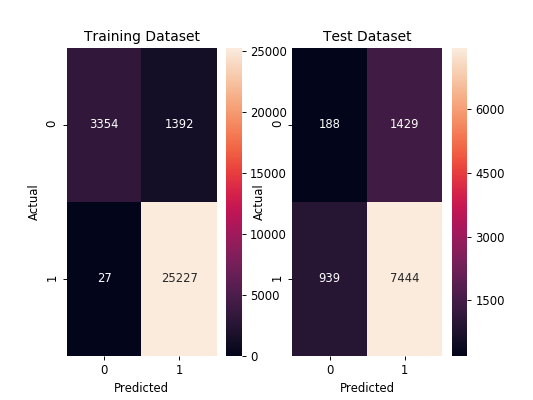

In [57]:
pred_train=clf.predict(tf_train)
pred_test=clf.predict(tf_cv)
con_mx(pred_train, y_train_50, pred_test, y_test_50)

### [5.2.3] Applying GBDT on AVG W2V,<font color='red'> SET 3</font>

### Hyperparameter tuning to find optimal depth and number of estimators

<IPython.core.display.Javascript object>


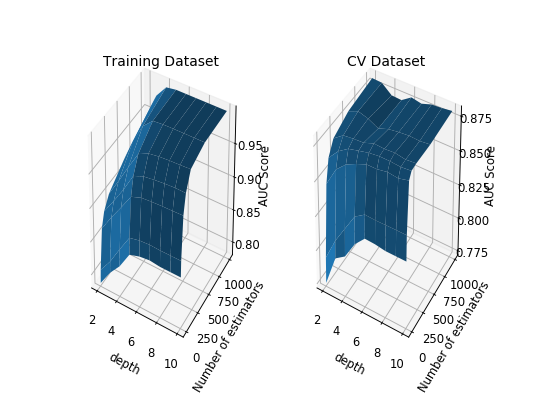

In [61]:
tune(train_w2v_50, cv_w2v_50, y_train_50,y_cv_50)

In [64]:
clf=LGBMClassifier(max_depth=4, n_estimators=200, class_weight='balanced')
clf.fit(train_w2v_50,y_train_50)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
        max_depth=4, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

<IPython.core.display.Javascript object>


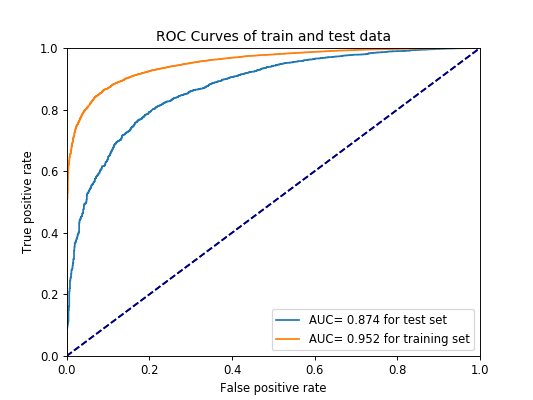

In [65]:
rocPlot(train_w2v_50, test_w2v_50, y_train_50, y_test_50)

### Confusion matrix plot training and test dataset

<IPython.core.display.Javascript object>


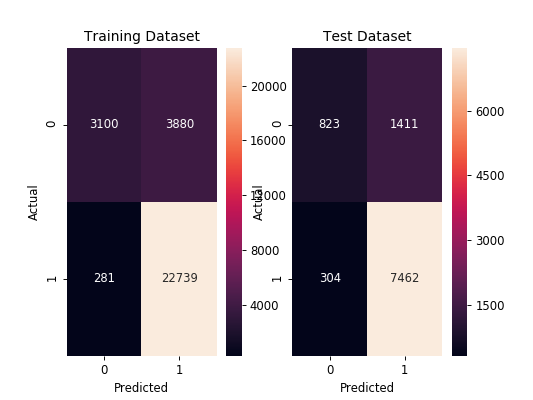

In [68]:
pred_train=clf.predict(train_w2v_50)
pred_test=clf.predict(test_w2v_50)
con_mx(pred_train, y_train_50, pred_test, y_test_50)

### [5.2.4] Applying GBDT on TFIDF W2V,<font color='red'> SET 4</font>

### Hyperparameter tuning to find optimal depth and number of estimators

<IPython.core.display.Javascript object>


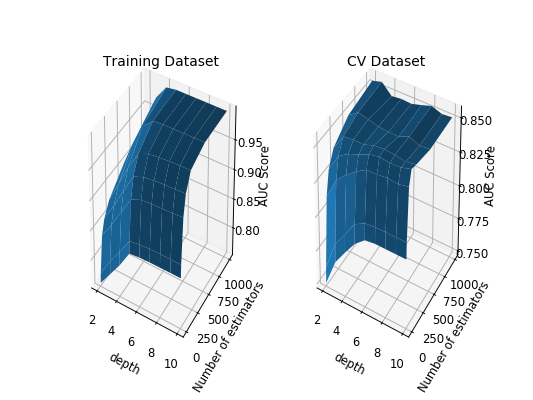

In [69]:
tune(train_df_50, cv_df_50, y_train_50,y_cv_50)

In [82]:
clf=LGBMClassifier(max_depth=4, n_estimators=250, class_weight='balanced')
clf.fit(train_df_50,y_train_50)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
        max_depth=4, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=250, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

<IPython.core.display.Javascript object>


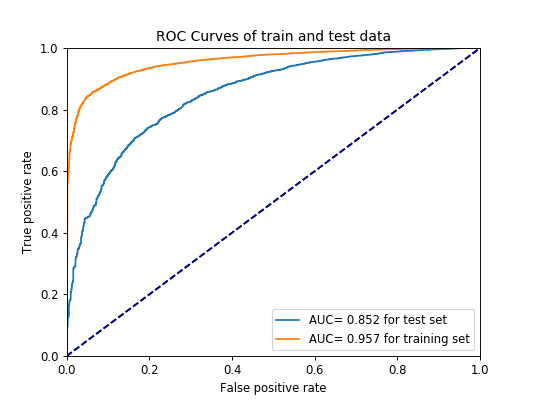

In [83]:
rocPlot(train_df_50, test_df_50, y_train_50, y_test_50)

### Confusion matrix plot training and test dataset

<IPython.core.display.Javascript object>


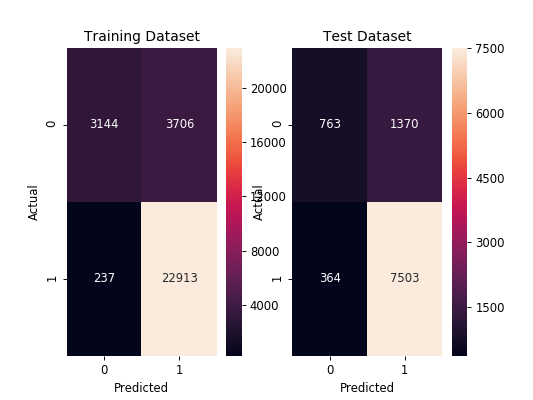

In [84]:
pred_train=clf.predict(train_df_50)
pred_test=clf.predict(test_df_50)
con_mx(pred_train, y_train_50, pred_test, y_test_50)

# [6] Conclusions

### Result for Random Forest

In [56]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names=["Vectorizer", "Depth", "Number of estimators","AUC_test_set"]
x.add_row(["BOW", 10, 1000,0.917])
x.add_row(["TF-IDF",9, 1000,0.91])
x.add_row(["AVG W2V",10, 500,0.878])
x.add_row(["TFIDF W2V",9,500,0.854])
print(x)

+------------+-------+----------------------+--------------+
| Vectorizer | Depth | Number of estimators | AUC_test_set |
+------------+-------+----------------------+--------------+
|    BOW     |   10  |         1000         |    0.917     |
|   TF-IDF   |   9   |         1000         |     0.91     |
|  AVG W2V   |   10  |         500          |    0.878     |
| TFIDF W2V  |   9   |         500          |    0.854     |
+------------+-------+----------------------+--------------+


### Result for Gradient Boosted Decision Tree

In [143]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names=["Vectorizer", "Depth", "Number of estimators","AUC_test_set"]
x.add_row(["BOW", 6, 700,0.923])
x.add_row(["TF-IDF",8, 450,0.921])
x.add_row(["AVG W2V",4, 200,0.874])
x.add_row(["TFIDF W2V",4,250,0.852])
print(x)

+------------+-------+----------------------+--------------+
| Vectorizer | Depth | Number of estimators | AUC_test_set |
+------------+-------+----------------------+--------------+
|    BOW     |   6   |         700          |    0.923     |
|   TF-IDF   |   8   |         450          |    0.921     |
|  AVG W2V   |   4   |         200          |    0.874     |
| TFIDF W2V  |   4   |         250          |    0.852     |
+------------+-------+----------------------+--------------+


here i've  applied Random forest and gradient boosting on Decision tree.
Since, Random forest model is based on fitting overfitting tree models(high variance, low bias), which result final model as low bias, low bias(bagging). 

I've used Light GBM framework instead of Xgboost with 50k data points.Here, we fit models with high bias and low variance and improve models subsequently by training on error on previous mode(boosting). We can see that auc scores of gbdt is better tahn of RF even with less half of data points has been taken. 